In [1]:
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import cv2
import torch
import sam2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor as SAM
from lang_sam.models.gdino import GDINO
from PIL import Image

/work/hpc/miniconda3/envs/potato/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [16]:
%set_env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [17]:
def compute_iou(box1, box2):
    """Compute Intersection over Union (IoU) between two xyxy boxes."""
    x1, y1, x2, y2 = box1
    x1_p, y1_p, x2_p, y2_p = box2

    # Compute intersection
    xi1, yi1 = max(x1, x1_p), max(y1, y1_p)
    xi2, yi2 = min(x2, x2_p), min(y2, y2_p)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    # Compute union
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

def compute_liou(box1, box2): 
    """Compute Intersection over Union (IoU) between two xyxy boxes."""
    x1, y1, x2, y2 = box1
    x1_p, y1_p, x2_p, y2_p = box2

    # Compute intersection
    xi1, yi1 = max(x1, x1_p), max(y1, y1_p)
    xi2, yi2 = min(x2, x2_p), min(y2, y2_p)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    # Compute union
    box1_area = (x2 - x1) * (y2 - y1)

    return inter_area / box1_area if box1_area > 0 else 0
    
def non_max_suppression(boxes, iou_threshold=0.5):
    """Prune overlapping bounding boxes using Non-Maximum Suppression (NMS)."""
    if len(boxes) == 0:
        return []

    # Sort boxes by area (largest first)
    boxes = sorted(boxes, key=lambda b: (b[2] - b[0]) * (b[3] - b[1]), reverse=True)
    selected_boxes = []

    while boxes:
        best_box = boxes.pop(0)
        selected_boxes.append(best_box)
        
        boxes = [box for box in boxes if compute_iou(best_box, box) < iou_threshold]

    return selected_boxes

In [18]:
gdino = GDINO()
sam = SAM(build_sam2("configs/sam2.1/sam2.1_hiera_s.yaml", "/work/hpc/potato/sam/sam2/checkpoints/sam2.1_hiera_small.pt"))

preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/933M [00:00<?, ?B/s]

In [ ]:
##### data = cv2.imread("../data/v2/2015.png", cv2.IMREAD_UNCHANGED)
image = data[:, :, :3][..., ::-1]
mask = data[..., 3]
plt.imshow(image[:512, :512])

In [26]:
patch_size = np.array([512, 512])
steps = 20
sampling_shape = mask.shape - patch_size - 1
print(sampling_shape)
x = np.linspace(0, 1, steps)
mesh = np.stack(np.meshgrid(x,x), axis=2).reshape(-1, 2) * sampling_shape
mesh = mesh.astype(int)
print(mesh.max())

[5704 3081]
5704


In [27]:
batch_size=2
threshold = 0.4
text = "waterline"
boxes = []
box_check = np.zeros([steps, steps])
for i in tqdm.tqdm(range(0, mesh.shape[0], batch_size), desc="Inference on GDINO"):
    inputs = []
    for j in range(i, i+batch_size):
        base = mesh[j]
        inputs.append(Image.fromarray(image[base[0]:base[0] + patch_size[0], base[1]:base[1] + patch_size[1]]))
    prompts = [text] * batch_size
    results = gdino.predict(inputs, prompts, 0.3, 0.25)
    for idx, result in enumerate(results):
        if result['labels']:
            index = i + idx
            x, y = index % steps, index // steps
            box = result['boxes'].cpu().numpy()
            scores = result['scores'].cpu().numpy()
            # print(scores.shape)
            pick = np.where(scores > threshold)[0]
            res = np.concatenate([box[pick], scores[pick][:, None]], axis=1)
            # print(result['scores'].cpu().numpy().max())
            if len(pick) > 0:
                # print(pick)
                box_check[x, y] = scores[pick].min()
                boxes.append(res)
            else: 
                boxes.append([])
    del results

Inference on GDINO: 100%|███████████████████████████████████████████████| 200/200 [04:06<00:00,  1.23s/it]


Inference on GDINO: 100%|██████████| 1024/1024 [28:06<00:00,  1.65s/it]


In [28]:
valid_boxes = []
for i, box in enumerate(boxes): 
    for b in box:
        c = mesh[i]
        valid_boxes.append([b[0] + c[1], b[1] + c[0], b[2] + c[1], b[3] + c[0]])
valid_boxes = np.array(valid_boxes).astype(int)

In [32]:
pruned = non_max_suppression(valid_boxes, iou_threshold=0.7)
print(len(pruned))
pruned = np.array(pruned)
with open("/work/hpc/potato/airc/data/sam/2015_box_0.5_0.7.npy", "wb") as f:
    np.save(f, pruned)


161


In [33]:
boxes = np.load("/work/hpc/potato/airc/data/sam/2015_box_0.5_0.7.npy")
# pruned = non_max_suppression(boxes, 0.)

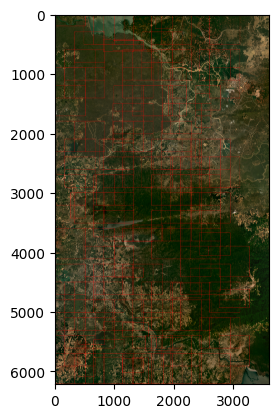

In [34]:
viz  = image.copy()
for box in boxes:
    cv2.rectangle(viz, box[:2], box[2:], (255, 0, 0), 2)
cv2.imwrite("/work/hpc/potato/airc/data/viz/boxes.jpeg", viz[..., ::-1])
plt.imshow(viz)

In [38]:
def find_boxes(boxes, base, size, checked=None, minArae=0.3):
    minArea = 0.3 * size[0] * size[1]
    dst = base + size
    window = np.array([base[1], base[0], base[1], base[0]])
    cand = boxes - window
    valid = np.where(cand < 0, 0, cand)
    if not checked:
        checked = [False] * len(boxes)
    for i in range(size.shape[0]):
        valid[:, i] = np.where(valid[:, i] > size[i], size[i], valid[:, i])
        j = i + 2
        valid[:, j] = np.where(valid[:, j] > size[i], size[i], valid[:, j])
    # print(valid, base, window)
    checked = [box for check, box in zip(checked, valid) if (max(box[2] - box[0], 0) * max(box[3] - box[1], 0) >= minArea) and not check]
    return sorted(checked, key=lambda box: -max(box[2] - box[0], 0) * max(box[3] - box[1], 0))


3 [array([  0,   0, 512, 511]), array([162,   0, 512, 511]), array([  0, 299, 512, 512])]
3


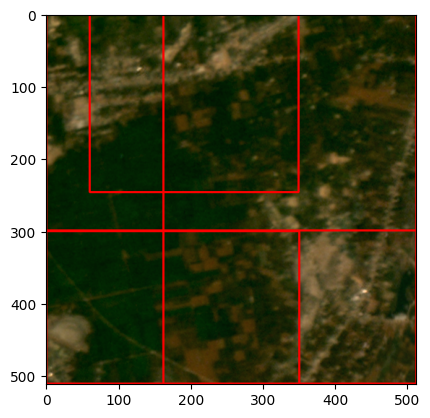

In [41]:
c = mesh[200]
valid = find_boxes(np.array(pruned), c, patch_size, minArae=0.3)
print(len(valid), valid)
plt.imshow(viz[c[0]:c[0] + 512, c[1]:c[1] + 512])
post_box = non_max_suppression(valid, 0.7)
print(len(post_box))

In [62]:
sigmoid = lambda x: 1 /(1 + np.exp(-x))
o_weights = np.full(image.shape[:2], 1e-3)
o_scores = np.full(image.shape[:2], 0.5) * o_weights
o_logits = np.zeros(image.shape[:2], dtype=float)
kernel = np.zeros(patch_size, dtype=float)
kernel[255, 255] = 100
kernel = cv2.GaussianBlur(kernel, (0, 0), 200, 200)
kernel /= kernel.max()

null_thresh = 0.85
pos_threshold = 0.25
used = [False] * len(pruned)
for i in tqdm.tqdm(range(len(pruned)), desc="SAM Inference"):
    c = pruned[i, :2]
    h, w, _ = image.shape
    dst = np.array([min(w, c[0] + patch_size[1]), min(h, c[1] + patch_size[0])], dtype=int)
    print(c, dst, h, w)
    # input_score = (o_scores / o_weights)[c[0]:dst[0], c[1]:dst[1]]
    # input_mask = (o_logits / o_weights)[c[0]:dst[0], c[1]:dst[1]]
    # print(input_score)
    # input_mask = np.where(input_mask > input_score, 1, 0).astype(np.uint8)
    # input_mask = cv2.resize(input_mask, (256, 256))
    boxis= find_boxes(pruned, c, patch_size, used, minArae=0.3)
    if len(boxis) == 0:
        continue
    # used = [use + (compute_liou(box, window) > 0.9) for use, box in zip(used, pruned)]
    
    # Get biggest box
    post_box = non_max_suppression(boxis, 0.6)[0]
    patch = Image.fromarray(image[c[1]:dst[1], c[0]:dst[0]])
    sam.set_image(patch)
    masks, scores, logits = sam.predict(box=post_box, mask_input=None, multimask_output=False, return_logits=True)
    print(masks.shape, scores, logits.shape)
    mask, score, logit = masks[0], scores[0], logits[0]
    if score < pos_threshold or np.mean(mask) > null_thresh:
        pass
        # o_weights[c[0]:dst[0], c[1]:dst[1]] += kernel * score
        # o_scores[c[0]:dst[0], c[1]:dst[1]] = 0 * o_weights[c[0]:dst[0], c[1]:dst[1]]
    else:
        print(logit.shape, c, dst)
        logit = cv2.resize(logit, patch_size)
        logit = sigmoid(logit)
        w = kernel * score 
        o_logits[c[1]:dst[1], c[0]:dst[0]] += logit * w
        o_weights[c[1]:dst[1], c[0]:dst[0]] += w  
        o_scores[c[1]:dst[1], c[0]:dst[0]] += score * w        
    
    


SAM Inference:   0%|                                                              | 0/161 [00:00<?, ?it/s]

[   0 1199] [ 512 1711] 6217 3594
[   0 1800] [ 512 2312] 6217 3594


SAM Inference:   1%|▋                                                     | 2/161 [00:00<00:21,  7.48it/s]

(1, 512, 512) [0.86328125] (1, 256, 256)
(256, 256) [   0 1800] [ 512 2312]
[   0 2700] [ 512 3212] 6217 3594


SAM Inference:   2%|█                                                     | 3/161 [00:00<00:29,  5.31it/s]

(1, 512, 512) [0.875] (1, 256, 256)
(256, 256) [   0 2700] [ 512 3212]
[   0 3602] [ 512 4114] 6217 3594
[   0 4202] [ 512 4714] 6217 3594
[   0 4502] [ 512 5014] 6217 3594
[   0 4803] [ 512 5315] 6217 3594
[   0 5703] [ 512 6215] 6217 3594
[162 600] [ 674 1112] 6217 3594


SAM Inference:   6%|███                                                   | 9/161 [00:00<00:12, 12.56it/s]

(1, 512, 512) [0.79296875] (1, 256, 256)
(256, 256) [162 600] [ 674 1112]
[161 899] [ 673 1411] 6217 3594


SAM Inference:   7%|███▌                                                 | 11/161 [00:01<00:13, 11.41it/s]

(1, 512, 512) [0.86328125] (1, 256, 256)
(256, 256) [161 899] [ 673 1411]
[ 162 2100] [ 674 2612] 6217 3594
[ 162 2401] [ 674 2913] 6217 3594


SAM Inference:   8%|████▎                                                | 13/161 [00:01<00:13, 10.64it/s]

(1, 512, 512) [0.54296875] (1, 256, 256)
(256, 256) [ 162 2401] [ 674 2913]
[ 162 4503] [ 674 5015] 6217 3594
[ 162 4802] [ 674 5314] 6217 3594
[ 162 5102] [ 674 5614] 6217 3594
[ 162 5403] [ 674 5915] 6217 3594
[324 299] [836 811] 6217 3594


SAM Inference:  11%|█████▌                                               | 17/161 [00:01<00:11, 12.96it/s]

(1, 512, 512) [0.83203125] (1, 256, 256)
[323 600] [ 835 1112] 6217 3594
(1, 512, 512) [0.80859375] (1, 256, 256)
(256, 256) [323 600] [ 835 1112]
[323 899] [ 835 1411] 6217 3594


SAM Inference:  12%|██████▎                                              | 19/161 [00:01<00:16,  8.36it/s]

(1, 512, 512) [0.7109375] (1, 256, 256)
(256, 256) [323 899] [ 835 1411]
[ 324 1800] [ 836 2312] 6217 3594


SAM Inference:  12%|██████▌                                              | 20/161 [00:02<00:18,  7.46it/s]

(1, 512, 512) [0.49023438] (1, 256, 256)
(256, 256) [ 324 1800] [ 836 2312]
[ 324 3001] [ 836 3513] 6217 3594
[ 324 4502] [ 836 5014] 6217 3594
[ 324 4803] [ 836 5315] 6217 3594
[ 323 5703] [ 835 6215] 6217 3594
[ 485 3601] [ 997 4113] 6217 3594
[ 486 3902] [ 998 4414] 6217 3594
[ 485 4802] [ 997 5314] 6217 3594
[ 485 5102] [ 997 5614] 6217 3594
[648   0] [1160  512] 6217 3594


SAM Inference:  18%|█████████▌                                           | 29/161 [00:02<00:08, 15.82it/s]

(1, 512, 512) [0.5546875] (1, 256, 256)
[ 648 2700] [1160 3212] 6217 3594


SAM Inference:  19%|██████████▏                                          | 31/161 [00:02<00:10, 12.84it/s]

(1, 512, 512) [0.875] (1, 256, 256)
(256, 256) [ 648 2700] [1160 3212]
[ 648 3002] [1160 3514] 6217 3594
[ 647 4201] [1159 4713] 6217 3594
[ 647 4502] [1159 5014] 6217 3594
[ 648 5703] [1160 6215] 6217 3594
[809   0] [1321  512] 6217 3594


SAM Inference:  22%|███████████▌                                         | 35/161 [00:02<00:08, 14.23it/s]

(1, 512, 512) [0.96875] (1, 256, 256)
(256, 256) [809   0] [1321  512]
[ 810 2101] [1322 2613] 6217 3594
[ 809 2401] [1321 2913] 6217 3594


SAM Inference:  23%|████████████▏                                        | 37/161 [00:03<00:09, 12.96it/s]

(1, 512, 512) [0.8046875] (1, 256, 256)
(256, 256) [ 809 2401] [1321 2913]
[ 809 2701] [1321 3213] 6217 3594


SAM Inference:  24%|████████████▊                                        | 39/161 [00:03<00:10, 11.72it/s]

(1, 512, 512) [0.80859375] (1, 256, 256)
(256, 256) [ 809 2701] [1321 3213]
[ 809 3001] [1321 3513] 6217 3594
[ 810 3302] [1322 3814] 6217 3594
[ 809 3901] [1321 4413] 6217 3594
[ 810 4201] [1322 4713] 6217 3594
[ 809 5704] [1321 6216] 6217 3594
[ 971 1501] [1483 2013] 6217 3594


SAM Inference:  27%|██████████████▍                                      | 44/161 [00:03<00:08, 13.40it/s]

(1, 512, 512) [0.82421875] (1, 256, 256)
(256, 256) [ 971 1501] [1483 2013]
[ 971 1801] [1483 2313] 6217 3594


SAM Inference:  29%|███████████████▏                                     | 46/161 [00:03<00:09, 12.41it/s]

(1, 512, 512) [0.02600098] (1, 256, 256)
[ 971 4803] [1483 5315] 6217 3594
[1135  599] [1647 1111] 6217 3594
[1135  899] [1647 1411] 6217 3594


SAM Inference:  30%|███████████████▊                                     | 48/161 [00:04<00:09, 11.63it/s]

(1, 512, 512) [0.75] (1, 256, 256)
(256, 256) [1135  899] [1647 1411]
[1134 1501] [1646 2013] 6217 3594
(1, 512, 512) [0.09130859] (1, 256, 256)
[1134 1800] [1646 2312] 6217 3594


SAM Inference:  31%|████████████████▍                                    | 50/161 [00:04<00:14,  7.86it/s]

(1, 512, 512) [0.453125] (1, 256, 256)
(256, 256) [1134 1800] [1646 2312]
[1135 2400] [1647 2912] 6217 3594


SAM Inference:  32%|████████████████▊                                    | 51/161 [00:04<00:15,  7.03it/s]

(1, 512, 512) [0.68359375] (1, 256, 256)
(256, 256) [1135 2400] [1647 2912]
[1134 4202] [1646 4714] 6217 3594
[1135 5704] [1647 6216] 6217 3594
[1296 1200] [1808 1712] 6217 3594


SAM Inference:  34%|█████████████████▊                                   | 54/161 [00:05<00:12,  8.47it/s]

(1, 512, 512) [0.69140625] (1, 256, 256)
(256, 256) [1296 1200] [1808 1712]
[1297 4202] [1809 4714] 6217 3594
[1297 4803] [1809 5315] 6217 3594
[1297 5102] [1809 5614] 6217 3594
[1459  300] [1971  812] 6217 3594


SAM Inference:  36%|███████████████████                                  | 58/161 [00:05<00:09, 10.58it/s]

(1, 512, 512) [0.14160156] (1, 256, 256)
[1458  599] [1970 1111] 6217 3594
[1459 1199] [1971 1711] 6217 3594


SAM Inference:  37%|███████████████████▊                                 | 60/161 [00:05<00:10,  9.27it/s]

(1, 512, 512) [0.6015625] (1, 256, 256)
(256, 256) [1459 1199] [1971 1711]
[1458 4502] [1970 5014] 6217 3594
[1459 4803] [1971 5315] 6217 3594
[1459 5704] [1971 6216] 6217 3594
[1621  299] [2133  811] 6217 3594


SAM Inference:  40%|█████████████████████                                | 64/161 [00:05<00:08, 11.67it/s]

(1, 512, 512) [0.35546875] (1, 256, 256)
(256, 256) [1621  299] [2133  811]
[1621  599] [2133 1111] 6217 3594


SAM Inference:  41%|█████████████████████▋                               | 66/161 [00:06<00:08, 10.94it/s]

(1, 512, 512) [0.9453125] (1, 256, 256)
(256, 256) [1621  599] [2133 1111]
[1621 2701] [2133 3213] 6217 3594
[1620 3302] [2132 3814] 6217 3594
[1620 3602] [2132 4114] 6217 3594
[1620 4502] [2132 5014] 6217 3594
[1620 4803] [2132 5315] 6217 3594
[1621 5703] [2133 6215] 6217 3594
[1783  600] [2295 1112] 6217 3594


SAM Inference:  45%|███████████████████████▋                             | 72/161 [00:06<00:05, 15.29it/s]

(1, 512, 512) [0.75390625] (1, 256, 256)
(256, 256) [1783  600] [2295 1112]
[1783 1801] [2295 2313] 6217 3594
(1, 512, 512) [0.4765625] (1, 256, 256)
(256, 256) [1783 1801] [2295 2313]
[1783 2100] [2295 2612] 6217 3594


SAM Inference:  46%|████████████████████████▎                            | 74/161 [00:06<00:09,  9.12it/s]

(1, 512, 512) [0.87109375] (1, 256, 256)
(256, 256) [1783 2100] [2295 2612]
[1783 2700] [2295 3212] 6217 3594
[1782 3002] [2294 3514] 6217 3594
[1782 3302] [2294 3814] 6217 3594
[1782 5403] [2294 5915] 6217 3594
[1945 1500] [2457 2012] 6217 3594


SAM Inference:  49%|██████████████████████████                           | 79/161 [00:07<00:07, 11.71it/s]

(1, 512, 512) [0.87109375] (1, 256, 256)
(256, 256) [1945 1500] [2457 2012]
[1944 2400] [2456 2912] 6217 3594
(1, 512, 512) [0.91796875] (1, 256, 256)
(256, 256) [1944 2400] [2456 2912]
[1944 2700] [2456 3212] 6217 3594


SAM Inference:  50%|██████████████████████████▋                          | 81/161 [00:07<00:09,  8.01it/s]

(1, 512, 512) [0.8671875] (1, 256, 256)
(256, 256) [1944 2700] [2456 3212]
[1944 3002] [2456 3514] 6217 3594
[1944 3302] [2456 3814] 6217 3594
[1945 4802] [2457 5314] 6217 3594
[1945 5403] [2457 5915] 6217 3594
[1945 5704] [2457 6216] 6217 3594
[2107 2401] [2619 2913] 6217 3594


SAM Inference:  54%|████████████████████████████▋                        | 87/161 [00:08<00:06, 11.29it/s]

(1, 512, 512) [0.24902344] (1, 256, 256)
[2107 2701] [2619 3213] 6217 3594


SAM Inference:  55%|█████████████████████████████▎                       | 89/161 [00:08<00:07, 10.10it/s]

(1, 512, 512) [0.953125] (1, 256, 256)
(256, 256) [2107 2701] [2619 3213]
[2107 3001] [2619 3513] 6217 3594
[2107 3302] [2619 3814] 6217 3594
[2107 3602] [2619 4114] 6217 3594
[2107 3901] [2619 4413] 6217 3594
[2108 4803] [2620 5315] 6217 3594
[2269 2101] [2781 2613] 6217 3594


SAM Inference:  58%|██████████████████████████████▉                      | 94/161 [00:08<00:05, 12.05it/s]

(1, 512, 512) [0.48242188] (1, 256, 256)
(256, 256) [2269 2101] [2781 2613]
[2269 2401] [2781 2913] 6217 3594
(1, 512, 512) [0.82421875] (1, 256, 256)
(256, 256) [2269 2401] [2781 2913]
[2269 2700] [2781 3212] 6217 3594


SAM Inference:  60%|███████████████████████████████▌                     | 96/161 [00:09<00:07,  8.68it/s]

(1, 512, 512) [0.875] (1, 256, 256)
(256, 256) [2269 2700] [2781 3212]
[2269 3002] [2781 3514] 6217 3594
[2269 3302] [2781 3814] 6217 3594
[2269 3602] [2781 4114] 6217 3594
[2431  599] [2943 1111] 6217 3594


SAM Inference:  62%|████████████████████████████████▎                   | 100/161 [00:09<00:06,  9.71it/s]

(1, 512, 512) [0.7109375] (1, 256, 256)
(256, 256) [2431  599] [2943 1111]
[2431 2101] [2943 2613] 6217 3594
(1, 512, 512) [0.5234375] (1, 256, 256)
(256, 256) [2431 2101] [2943 2613]
[2431 2401] [2943 2913] 6217 3594


SAM Inference:  63%|████████████████████████████████▉                   | 102/161 [00:09<00:07,  7.72it/s]

(1, 512, 512) [0.42382812] (1, 256, 256)
(256, 256) [2431 2401] [2943 2913]
[2431 3002] [2943 3514] 6217 3594
[2432 4201] [2944 4713] 6217 3594
[2432 5103] [2944 5615] 6217 3594
[2432 5703] [2944 6215] 6217 3594
[2594    0] [3106  512] 6217 3594


SAM Inference:  66%|██████████████████████████████████▌                 | 107/161 [00:10<00:05,  9.69it/s]

(1, 512, 512) [0.84375] (1, 256, 256)
(256, 256) [2594    0] [3106  512]
[2593  599] [3105 1111] 6217 3594
(1, 512, 512) [0.78515625] (1, 256, 256)
(256, 256) [2593  599] [3105 1111]
[2593  900] [3105 1412] 6217 3594


SAM Inference:  68%|███████████████████████████████████▏                | 109/161 [00:10<00:06,  7.60it/s]

(1, 512, 512) [0.71484375] (1, 256, 256)
(256, 256) [2593  900] [3105 1412]
[2593 2400] [3105 2912] 6217 3594


SAM Inference:  68%|███████████████████████████████████▌                | 110/161 [00:11<00:07,  6.91it/s]

(1, 512, 512) [0.21484375] (1, 256, 256)
[2594 4503] [3106 5015] 6217 3594
[2594 5102] [3106 5614] 6217 3594
[2756 3901] [3268 4413] 6217 3594
[2755 5403] [3267 5915] 6217 3594
[  0 900] [ 512 1412] 6217 3594


SAM Inference:  71%|█████████████████████████████████████▏              | 115/161 [00:11<00:04,  9.39it/s]

(1, 512, 512) [0.92578125] (1, 256, 256)
(256, 256) [  0 900] [ 512 1412]
[   0 5403] [ 512 5915] 6217 3594
[485   0] [997 512] 6217 3594


SAM Inference:  73%|█████████████████████████████████████▊              | 117/161 [00:11<00:04,  9.04it/s]

(1, 512, 512) [0.47460938] (1, 256, 256)
(256, 256) [485   0] [997 512]
[1621    0] [2133  512] 6217 3594


SAM Inference:  73%|██████████████████████████████████████              | 118/161 [00:11<00:05,  7.85it/s]

(1, 512, 512) [0.21777344] (1, 256, 256)
[1783    0] [2295  512] 6217 3594


SAM Inference:  74%|██████████████████████████████████████▍             | 119/161 [00:12<00:06,  6.42it/s]

(1, 512, 512) [0.8359375] (1, 256, 256)
[1458 2401] [1970 2913] 6217 3594


SAM Inference:  75%|██████████████████████████████████████▊             | 120/161 [00:12<00:07,  5.68it/s]

(1, 512, 512) [0.48046875] (1, 256, 256)
(256, 256) [1458 2401] [1970 2913]
[1621 2101] [2133 2613] 6217 3594


SAM Inference:  75%|███████████████████████████████████████             | 121/161 [00:12<00:07,  5.21it/s]

(1, 512, 512) [0.77734375] (1, 256, 256)
(256, 256) [1621 2101] [2133 2613]
[1822 5703] [2334 6215] 6217 3594
[ 648 3302] [1160 3814] 6217 3594
[ 988 1200] [1500 1712] 6217 3594


SAM Inference:  77%|████████████████████████████████████████            | 124/161 [00:12<00:05,  7.34it/s]

(1, 512, 512) [0.8984375] (1, 256, 256)
(256, 256) [ 988 1200] [1500 1712]
[1297  623] [1809 1135] 6217 3594
[ 753 2100] [1265 2612] 6217 3594
[ 384 5103] [ 896 5615] 6217 3594
[2269 4271] [2781 4783] 6217 3594
[2431 3672] [2943 4184] 6217 3594
[2365 1200] [2877 1712] 6217 3594


SAM Inference:  81%|█████████████████████████████████████████▉          | 130/161 [00:13<00:02, 11.26it/s]

(1, 512, 512) [0.91015625] (1, 256, 256)
(256, 256) [2365 1200] [2877 1712]
[2755 4627] [3267 5139] 6217 3594
[1903 1200] [2415 1712] 6217 3594


SAM Inference:  82%|██████████████████████████████████████████▋         | 132/161 [00:13<00:02, 10.26it/s]

(1, 512, 512) [0.85546875] (1, 256, 256)
(256, 256) [1903 1200] [2415 1712]
[ 699 2701] [1211 3213] 6217 3594


SAM Inference:  83%|███████████████████████████████████████████▎        | 134/161 [00:13<00:02,  9.65it/s]

(1, 512, 512) [0.734375] (1, 256, 256)
(256, 256) [ 699 2701] [1211 3213]
[ 647 5469] [1159 5981] 6217 3594
[1807 1501] [2319 2013] 6217 3594


SAM Inference:  84%|███████████████████████████████████████████▌        | 135/161 [00:13<00:03,  7.78it/s]

(1, 512, 512) [0.73046875] (1, 256, 256)
(256, 256) [1807 1501] [2319 2013]
[1296 3545] [1808 4057] 6217 3594
[1944  900] [2456 1412] 6217 3594


SAM Inference:  85%|████████████████████████████████████████████▏       | 137/161 [00:14<00:03,  7.23it/s]

(1, 512, 512) [0.4296875] (1, 256, 256)
(256, 256) [1944  900] [2456 1412]
[1944 4518] [2456 5030] 6217 3594
[ 986 1801] [1498 2313] 6217 3594


SAM Inference:  86%|████████████████████████████████████████████▉       | 139/161 [00:14<00:02,  7.36it/s]

(1, 512, 512) [0.4296875] (1, 256, 256)
(256, 256) [ 986 1801] [1498 2313]
[1297 5776] [1809 6217] 6217 3594
[1134 3602] [1646 4114] 6217 3594
[1518 5403] [2030 5915] 6217 3594
[ 383 5704] [ 895 6216] 6217 3594
[1620 5436] [2132 5948] 6217 3594
[ 258 3002] [ 770 3514] 6217 3594
[810 424] [1322  936] 6217 3594


SAM Inference:  91%|███████████████████████████████████████████████▏    | 146/161 [00:14<00:01, 12.83it/s]

(1, 512, 512) [0.73046875] (1, 256, 256)
(256, 256) [810 424] [1322  936]
[1135 5185] [1647 5697] 6217 3594
[2365 1501] [2877 2013] 6217 3594


SAM Inference:  92%|███████████████████████████████████████████████▊    | 148/161 [00:15<00:01, 10.74it/s]

(1, 512, 512) [0.8515625] (1, 256, 256)
(256, 256) [2365 1501] [2877 2013]
[0 0] [512 512] 6217 3594


SAM Inference:  93%|████████████████████████████████████████████████▍   | 150/161 [00:15<00:01, 10.24it/s]

(1, 512, 512) [0.69140625] (1, 256, 256)
(256, 256) [0 0] [512 512]
[2108 4517] [2620 5029] 6217 3594
[2364 1338] [2876 1850] 6217 3594
(1, 512, 512) [0.5390625] (1, 256, 256)
(256, 256) [2364 1338] [2876 1850]
[972 440] [1484  952] 6217 3594


SAM Inference:  94%|█████████████████████████████████████████████████   | 152/161 [00:15<00:01,  7.52it/s]

(1, 512, 512) [0.83203125] (1, 256, 256)
(256, 256) [972 440] [1484  952]
[1131 5789] [1643 6217] 6217 3594
[ 972 4267] [1484 4779] 6217 3594
[1704 5436] [2216 5948] 6217 3594
[ 810 5170] [1322 5682] 6217 3594
[1681    0] [2193  512] 6217 3594


SAM Inference:  98%|██████████████████████████████████████████████████▋ | 157/161 [00:16<00:00,  9.71it/s]

(1, 512, 512) [0.36914062] (1, 256, 256)
[2756 4803] [3268 5315] 6217 3594
[2581 3901] [3093 4413] 6217 3594
[2364 2101] [2876 2613] 6217 3594


SAM Inference:  99%|███████████████████████████████████████████████████▋| 160/161 [00:16<00:00, 10.14it/s]

(1, 512, 512) [0.4453125] (1, 256, 256)
(256, 256) [2364 2101] [2876 2613]
[972 444] [1484  956] 6217 3594


SAM Inference: 100%|████████████████████████████████████████████████████| 161/161 [00:16<00:00,  9.65it/s]

(1, 512, 512) [0.83984375] (1, 256, 256)
(256, 256) [972 444] [1484  956]


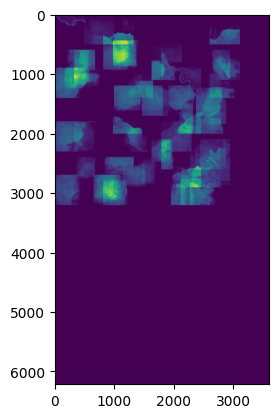

In [64]:
plt.imshow(o_logits)